In [16]:
##############################################################################
#                            RANDOM FOREST CLASSIFIER
##############################################################################

########## TABLE OF CONTENTS #############
#1. DATA READ IN
#2. DATA QUALITY CHECK
#3. DATA PREPARATION
#4. MODEL TRAINING -  BEST HYPER PARAMS SEARCH
#5. MODEL TRAINING - MODEL DEVELOPMENT
#6. MODEL PERFORMANCE EVALUATION

# Dataset -> Heart -> Taken from https://hastie.su.domains/ElemStatLearn/
######################

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
import scipy 
from scipy import stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, auc
import statsmodels.formula.api as smf
import math
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import shap 
from shap import TreeExplainer, Explanation
from shap.plots import waterfall

1. DATA READ IN

In [17]:
df = pd.read_csv("Heart.txt", index_col=0)
df

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...
459,214,0.40,5.98,31.72,Absent,64,28.45,0.00,58,0
460,182,4.20,4.41,32.10,Absent,52,28.61,18.72,52,1
461,108,3.00,1.59,15.23,Absent,40,20.09,26.64,55,0
462,118,5.40,11.61,30.79,Absent,64,27.35,23.97,40,0


2. DATA QUALITY CHECK

In [18]:
print(df['famhist'].value_counts())
df.shape
df.info()
df.describe()

cols = list(df.columns)


famhist
Absent     270
Present    192
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 1 to 463
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 39.7+ KB


3. DATA PREPARATION

In [19]:
df['familiarity'] = np.where(df['famhist'] == "Absent",0,np.where(df['famhist'] == "Present",1,-1))

ds = df.drop(columns=['famhist'], axis=1)
X = ds.drop(columns=['chd'], axis = 1)
Y = ds['chd']

pred_features = X.columns
print(pred_features)

# Correlation
corr = ds.corr()
display(corr)
corr.style.background_gradient(cmap='coolwarm')

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol',
       'age', 'familiarity'],
      dtype='object')


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,familiarity
sbp,1.000000,0.212247,0.158296,0.356500,-0.057454,0.238067,0.140096,0.388771,0.192354,0.085645
tobacco,0.212247,1.000000,0.158905,0.286640,-0.014608,0.124529,0.200813,0.450330,0.299718,0.088601
ldl,0.158296,0.158905,1.000000,0.440432,0.044048,0.330506,-0.033403,0.311799,0.263053,0.161353
adiposity,0.356500,0.286640,0.440432,1.000000,-0.043144,0.716556,0.100330,0.625954,0.254121,0.181721
typea,-0.057454,-0.014608,0.044048,-0.043144,1.000000,0.074006,0.039498,-0.102606,0.103156,0.044809
obesity,0.238067,0.124529,0.330506,0.716556,0.074006,1.000000,0.051620,0.291777,0.100095,0.115595
alcohol,0.140096,0.200813,-0.033403,0.100330,0.039498,0.051620,1.000000,0.101125,0.062531,0.080520
age,0.388771,0.450330,0.311799,0.625954,-0.102606,0.291777,0.101125,1.000000,0.372973,0.239667
chd,0.192354,0.299718,0.263053,0.254121,0.103156,0.100095,0.062531,0.372973,1.000000,0.272373
familiarity,0.085645,0.088601,0.161353,0.181721,0.044809,0.115595,0.080520,0.239667,0.272373,1.000000


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,familiarity
sbp,1.000000,0.212247,0.158296,0.356500,-0.057454,0.238067,0.140096,0.388771,0.192354,0.085645
tobacco,0.212247,1.000000,0.158905,0.286640,-0.014608,0.124529,0.200813,0.450330,0.299718,0.088601
ldl,0.158296,0.158905,1.000000,0.440432,0.044048,0.330506,-0.033403,0.311799,0.263053,0.161353
adiposity,0.356500,0.286640,0.440432,1.000000,-0.043144,0.716556,0.100330,0.625954,0.254121,0.181721
typea,-0.057454,-0.014608,0.044048,-0.043144,1.000000,0.074006,0.039498,-0.102606,0.103156,0.044809
obesity,0.238067,0.124529,0.330506,0.716556,0.074006,1.000000,0.051620,0.291777,0.100095,0.115595
alcohol,0.140096,0.200813,-0.033403,0.100330,0.039498,0.051620,1.000000,0.101125,0.062531,0.080520
age,0.388771,0.450330,0.311799,0.625954,-0.102606,0.291777,0.101125,1.000000,0.372973,0.239667
chd,0.192354,0.299718,0.263053,0.254121,0.103156,0.100095,0.062531,0.372973,1.000000,0.272373
familiarity,0.085645,0.088601,0.161353,0.181721,0.044809,0.115595,0.080520,0.239667,0.272373,1.000000


4. MODEL TRAINING -  BEST HYPER PARAMS SEARCH

In [20]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.50, random_state = 42)


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

5. MODEL TRAINING - MODEL DEVELOPMENT

age            0.165807
ldl            0.149599
adiposity      0.136772
sbp            0.127444
typea          0.116649
tobacco        0.096629
obesity        0.094161
alcohol        0.076758
familiarity    0.036181
dtype: float64


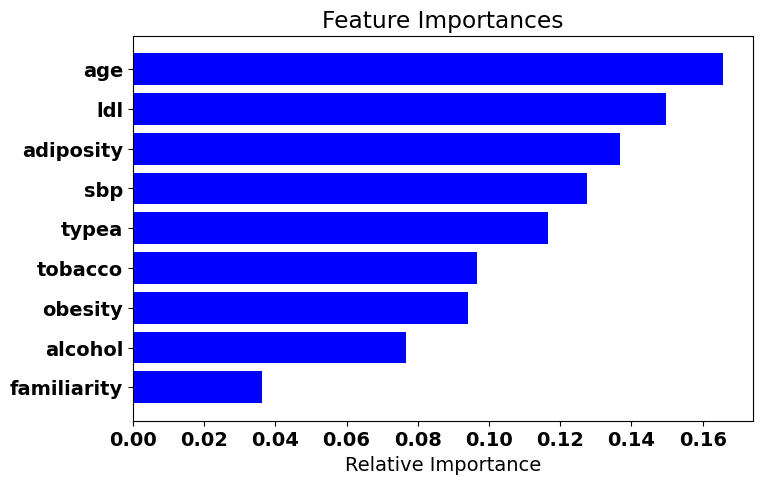

SHAP Waterfall graph


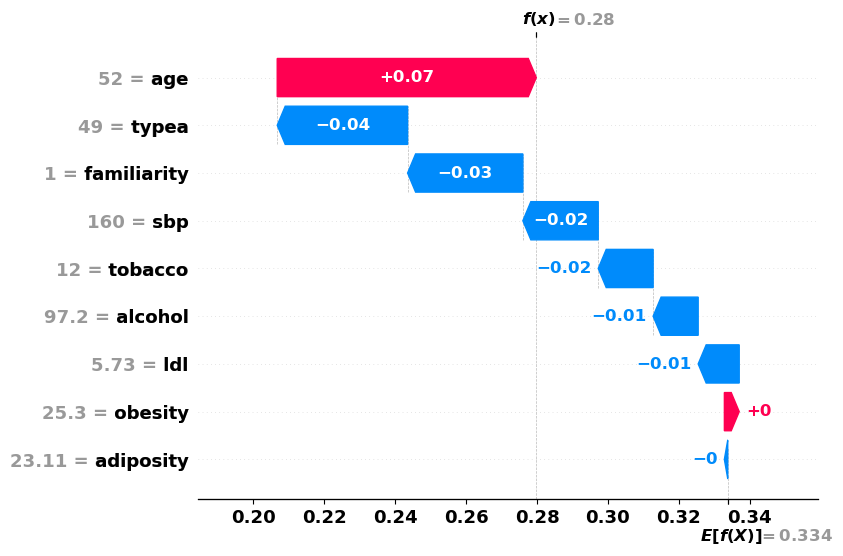


Model accuracy score on Train Sample : 0.9437
Model accuracy score on Test Sample: 0.6970
Confusion matrix

 [[123  25]
 [ 45  38]]
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       148
           1       0.60      0.46      0.52        83

    accuracy                           0.70       231
   macro avg       0.67      0.64      0.65       231
weighted avg       0.69      0.70      0.69       231

Gini for Train Sample is 0.994

Gini for Test Sample is 0.477



In [22]:
# Use the best hyper-parameters
clf = RandomForestClassifier(n_estimators=600, 
                                random_state=0,
                                min_samples_split = 10,
                                min_samples_leaf = 1,
                                max_features= 'auto',
                                bootstrap = True,
                                max_depth= 10
                                )

# Fit the model to the training set
clf.fit(X_train, y_train)
# Print features importance
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

# Plot features importance
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [pred_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# Calculate Shap values 

print("SHAP Waterfall graph") 
sv = explainer(X_train)
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X.values, 
                  feature_names=X.columns)
idx = 0
waterfall(exp[idx])

print("")

6. MODEL PERFORMANCE EVALUATION

In [23]:
# Accuracy Score on Train Sample
y_pred = clf.predict(X_train)
print('Model accuracy score on Train Sample : {0:0.4f}'. format(accuracy_score(y_train, y_pred)))

#Accuracy Score on Train Sample
y_pred = clf.predict(X_test)
print('Model accuracy score on Test Sample: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

# Confusion Matrix (on Test Sample)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))
    
# Gini calculation on Train Sample
y_pred_proba = clf.predict_proba(X_train)[:,1]
[fpr, tpr, thr] = roc_curve(y_train, y_pred_proba)
Gini = (auc(fpr, tpr)-0.5)*2
print("Gini for Train Sample is %2.3f" % Gini)
print("")

    
# Gini calculation on Test Sample
y_pred_proba = clf.predict_proba(X_test)[:,1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
Gini = (auc(fpr, tpr)-0.5)*2
print("Gini for Test Sample is %2.3f" % Gini)
print("")
    

Model accuracy score on Train Sample : 0.9437
Model accuracy score on Test Sample: 0.6970
Confusion matrix

 [[123  25]
 [ 45  38]]
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       148
           1       0.60      0.46      0.52        83

    accuracy                           0.70       231
   macro avg       0.67      0.64      0.65       231
weighted avg       0.69      0.70      0.69       231

Gini for Train Sample is 0.994

Gini for Test Sample is 0.477

